# Assignment 5: Telecom Churn

### Problem Statement

As a Data Scientist we are entasked to analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

OBJECTIVE:  is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months.

     Usage-based churn: Customers who have not done any usage, either incoming or outgoing - 
                        in terms of calls, internet etc. over a period of time.

#### Importing required Library  

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 300)  

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics                               # Accuracy
import sklearn.linear_model as lm
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import RandomOverSampler       # OVERSAMpLING of DATA
from sklearn.decomposition import PCA                      # PCA function from sklearn

from sklearn.linear_model import LogisticRegression        # Logistic Regression

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


#### Reading Data File

In [2]:
df = pd.read_csv('telecom_churn_data.csv')#,engine = 'python',na_values= np.nan)

####  High Value Customer Filtering 
    
       High-value customers as follows: Those who have recharged with an amount more than or 
       equal to X, where X is the 70th percentile of the average recharge amount in the first 
       two months

In [3]:
df['avg_rech_first_2_mths'] = (df['total_rech_amt_6'] + df['total_rech_amt_7'])/2
percentile_70 = np.percentile(df['avg_rech_first_2_mths'], 70)
temp_df = df[df['avg_rech_first_2_mths'] >= percentile_70]
temp_df.reset_index(drop = True, inplace = True)

In [4]:
df_cust_equal = temp_df.copy()
for i in range(len(df_cust_equal)):
    if (pd.isna(df_cust_equal.loc[i,'total_rech_data_6']) or (df_cust_equal.loc[i,'total_rech_data_6'] == 0)):
        df_cust_equal.loc[i, 'total_rech_data_6'] = 0
        if pd.isna(df_cust_equal.loc[i,'max_rech_data_6']):
            df_cust_equal.loc[i, 'max_rech_data_6'] = 0
        if pd.isna(df_cust_equal.loc[i,'av_rech_amt_data_6']):
            df_cust_equal.loc[i, 'av_rech_amt_data_6'] = 0

for i in range(len(df_cust_equal)):
    if (pd.isna(df_cust_equal.loc[i,'total_rech_data_9']) or (df_cust_equal.loc[i,'total_rech_data_9'] == 0)):
        df_cust_equal.loc[i, 'total_rech_data_9'] = 0
        if pd.isna(df_cust_equal.loc[i,'max_rech_data_9']):
            df_cust_equal.loc[i, 'max_rech_data_9'] = 0
        if pd.isna(df_cust_equal.loc[i,'av_rech_amt_data_9']):
            df_cust_equal.loc[i, 'av_rech_amt_data_9'] = 0

#### Tagging Churners  

    1. Churned customers are tagged as (churn=1, else 0) based on the fourth month (9th Month):
        
        * Those who have not made any calls (either incoming or outgoing) AND have not used mobile
        internet even once in the churn phase. The attributes you need to use to tag churners are:
        
            * total_ic_mou_9   *total_og_mou_9  *vol_2g_mb_9  *vol_3g_mb_9 
            
    2. After tagging churners, remove all the attributes corresponding to the churn phase 
       (all attributes having ‘ _9’, etc. in their names). 

In [5]:
# Summing values for 9th month to Tag Churners
df_cust_equal['sum'] = (df_cust_equal['total_ic_mou_9'] + 
                        df_cust_equal['total_og_mou_9'] +  
                        df_cust_equal['vol_2g_mb_9'] +  
                        df_cust_equal['vol_3g_mb_9'])
# Tagging Churners
df_cust_equal.loc[df_cust_equal['sum'] != 0.00 , 'Churn'] = 0
df_cust_equal.loc[df_cust_equal['sum'] == 0.00 , 'Churn'] = 1
df_cust_equal[ 'Churn'] = df_cust_equal[ 'Churn'].astype(int)

# Removing all attributes for 9th month
df_cust_equal = df_cust_equal[df_cust_equal.columns.drop(list(df_cust_equal.filter(regex='_9')))]


##### Dropping Undesired Columns from data

In [6]:
df_cust_equal.drop(['mobile_number', 'circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou',
                    'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'onnet_mou_6', 
                    'onnet_mou_7','onnet_mou_8','offnet_mou_6','offnet_mou_7','offnet_mou_8','std_og_t2c_mou_6',
                    'std_og_t2c_mou_7','std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8', 
                    'date_of_last_rech_6','date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_data_6', 
                    'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'av_rech_amt_data_6','av_rech_amt_data_7',
                    'av_rech_amt_data_8', 'sep_vbc_3g', 'avg_rech_first_2_mths', 'sum'], axis=1, inplace=True)

In [7]:
print(' Length of final datapoints : ', df_cust_equal.shape)
df_cust_equal.head(3)


 Length of final datapoints :  (30011, 143)


arpu_6    arpu_7    arpu_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0  1069.180  1349.850  3171.480          16.23          33.49          31.64   
1   378.721   492.223   137.362           0.00           0.00           0.00   
2   492.846   205.671   593.260          23.53         144.24          72.11   

   roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0          23.74          12.59          38.06             51.39   
1           0.00           0.00           0.00            297.13   
2           7.98          35.26           1.44             49.63   

   loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0             31.38             40.28            308.63            447.38   
1            217.59             12.49             80.96             70.58   
2              6.19             36.01            151.13             47.28   

   loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0            162.28             62.13             55.14             53.23   
1             50.54              0.00              0.00              0.00   
2            294.46              4.54              0.00             23.51   

   loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0               0.0               0.0              0.00        422.16   
1               0.0               0.0              7.15        378.09   
2               0.0               0.0              0.49        205.31   

   loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0        533.91        255.79              4.30             23.29   
1        288.18         63.04            116.56            133.43   
2         53.48        353.99            446.41             85.98   

   std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  \
0             12.01             49.89             31.76             49.14   
1             22.58             13.69             10.04             75.69   
2            498.23            255.36             52.94            156.94   

   std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  \
0              6.66             20.08             16.68         60.86   
1              0.00              0.00              0.00        130.26   
2              0.00              0.00              0.00        701.78   

   std_og_mou_7  std_og_mou_8  isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  \
0         75.14         77.84           0.0          0.18         10.01   
1        143.48         98.28           0.0          0.00          0.00   
2        138.93        655.18           0.0          0.00          1.29   

   spl_og_mou_6  spl_og_mou_7  spl_og_mou_8  og_others_6  og_others_7  \
0           4.5           0.0          6.50          0.0          0.0   
1           0.0           0.0         10.23          0.0          0.0   
2           0.0           0.0          4.78          0.0          0.0   

   og_others_8  total_og_mou_6  total_og_mou_7  total_og_mou_8  \
0          0.0          487.53          609.24          350.16   
1          0.0          508.36          431.66          171.56   
2          0.0          907.09          192.41         1015.26   

   loc_ic_t2t_mou_6  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  loc_ic_t2m_mou_6  \
0             58.14             32.26             27.31            217.56   
1             23.84              9.84              0.31             57.58   
2             67.88              7.58             52.58            142.88   

   loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_t2f_mou_6  loc_ic_t2f_mou_7  \
0            221.49            121.19            152.16            101.46   
1             13.98             15.48              0.00              0.00   
2             18.53            195.18              4.81              0.00   

   loc_ic_t2f_mou_8  loc_ic_mou_6  loc_ic_mou_7  loc_ic_mou_8  \
0             39.53        427.88        355.23        188.04   
1             

## Data Imputation 

     We are using the Impyute library for imputation of data.
     Since MICE takes a lot of time, we are imputting missing with 0 wherever possible

In [8]:
from impyute.imputation.cs import mice

In [9]:
#imputed_training = mice(df_cust_equal.to_numpy())
df_cust_equal.fillna(0, inplace=True)

## Analysis 

### Exploratory Data Analysis 

In [10]:
dataframe = df_cust_equal.copy()

##### Plotting the Correlation Matrix

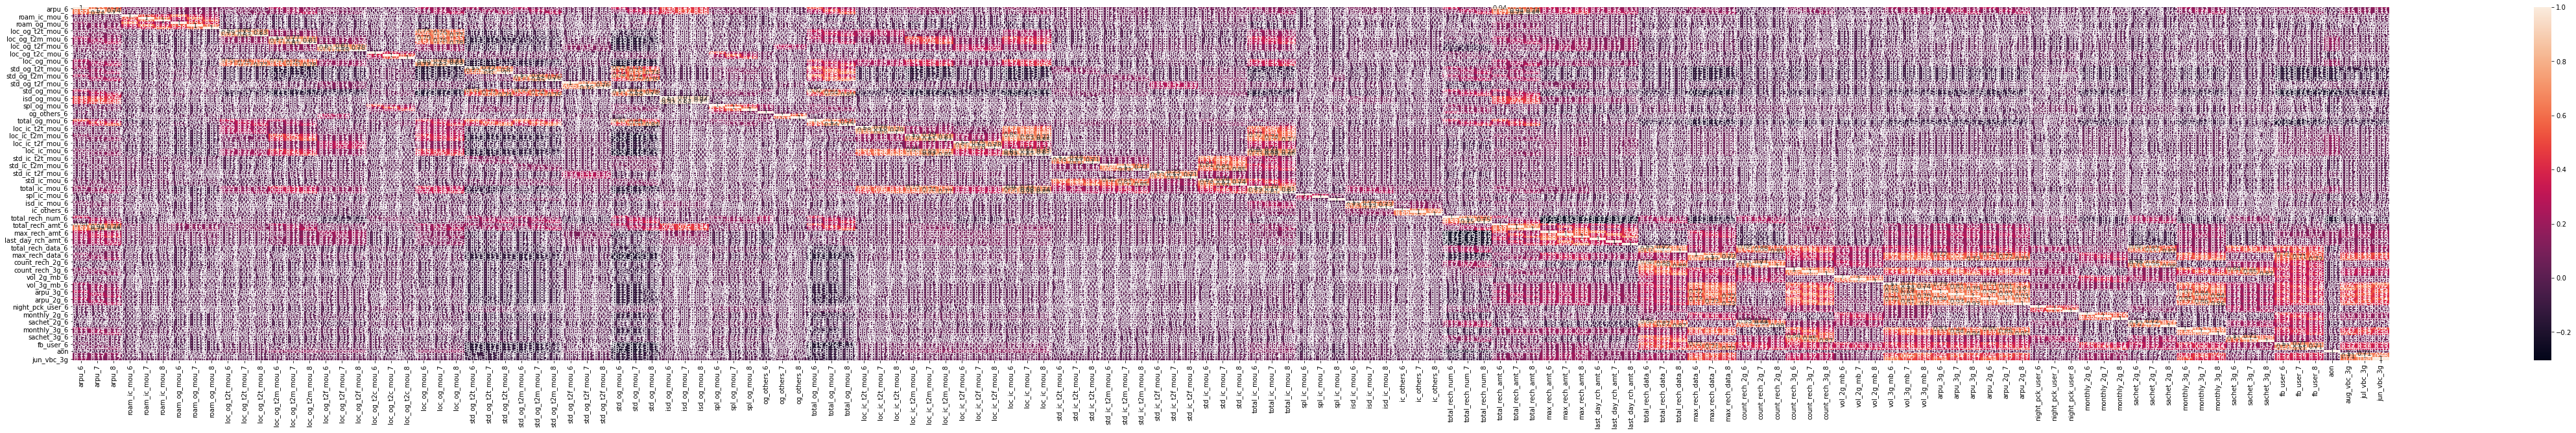

In [11]:
# Plotting the correlation matrix

plt.figure(figsize = (80,10))        # Size of the figure
sns.heatmap(dataframe[list(dataframe)[:-1]].corr(),annot = True)

####  Balancing the Data, Imbalanced vs Balanced Data

count_class_0 :  27418
count_class_1 :  2593


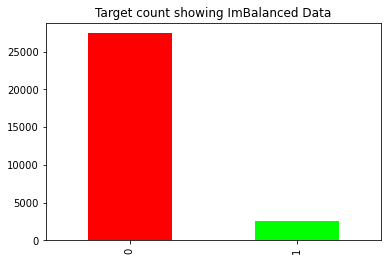

In [12]:
# Class count for data to check Balanced vs Imbalanced

count_class_0, count_class_1 = dataframe.Churn.value_counts()
dataframe.Churn.value_counts().plot(kind='bar', title='Target count showing ImBalanced Data',
                                    color = [[1,0,0],[0,1,0]]);

# Data is imbalanced
print('count_class_0 : ',count_class_0)
print('count_class_1 : ',count_class_1)

#### Oversampling the Data

    Oversampling is done using Imblearn Library

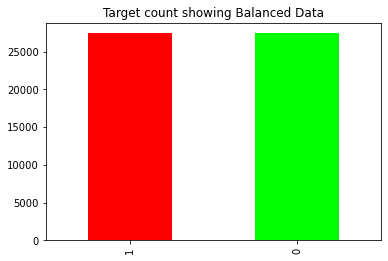

In [13]:
df_features = dataframe[list(dataframe)[:-1]]
df_y = dataframe.pop('Churn')                  # Popping the Churn Data column 
ros = RandomOverSampler()                      # Oversampling Data  
X, y = ros.fit_sample(df_features, df_y)

# Balanced Dataframe
df_ros = pd.concat([X, y], axis=1)
df_ros.Churn.value_counts().plot(kind='bar', title='Target count showing Balanced Data',
                                 color = [[1,0,0],[0,1,0]])

## Splitting the Data into Train & Test set 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7, 
                                                    test_size=0.3,
                                                    random_state=100)
sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
X_train[X_train.columns.to_list()] = sc.fit_transform(X_train[X_train.columns.to_list()])
X_test[X_test.columns.to_list()] = sc.transform(X_test[X_test.columns.to_list()])

### Pincipal Component Analysis    

    Performing PCA, we will get the number of Components that explain 90% of variance in data
    
####  MODEL 0 : PCA   
##### PCA is applied to X_train Dataset

In [15]:
pca = PCA(0.9)
pca.fit(X_train)
print('Shape of PCA :',pca.components_.shape)
print('Components of PCA :', pca.n_components_)

Shape of PCA : (56, 142)
Components of PCA : 56


##### RESULT :
                there are 56 variables that explain 90% of variation of Data
                
#### PCA on X_train dataset 

In [16]:
# PCA on train dataset
X_train_pca = pca.fit_transform(X_train)
X_train_pca.shape

(38385, 56)

##### Correlation Matrix after applying PCA
        Visualizing the correlation matrix after PCA

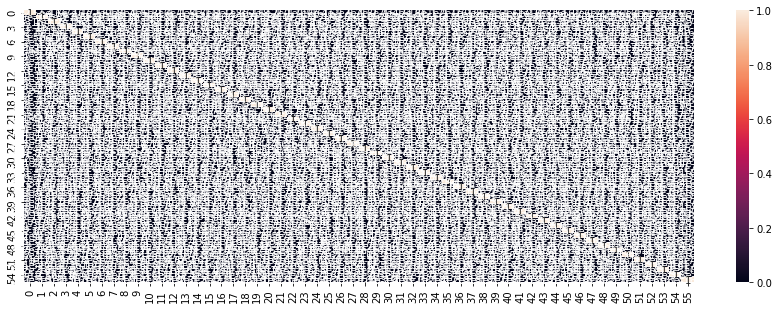

In [17]:
corrmat = np.corrcoef(X_train_pca.transpose())
plt.figure(figsize=[15,5])
sns.heatmap(corrmat, annot=True)

#### PCA on X_test data 

In [18]:
# PCA on test dataset
X_test_pca = pca.transform(X_test)
X_test_pca.shape

(16451, 56)

### Logistic Regression 
            Applying  Logistic Regression on our Principal Component Data
            
#### MODEL 1: Logistic + PCA

In [19]:
learner_pca = LogisticRegression()
model_pca = learner_pca.fit(X_train_pca, y_train)


       Model Performance Analysis of Logictic Regression on PCA Data on Test Data

In [20]:
# Checking model performance on test dataset
pred_probs_test = model_pca.predict_proba(X_test_pca)
y_pred_pca_df = pd.DataFrame(pred_probs_test)
y_pred_1 = y_pred_pca_df.iloc[:,[1]]
y_pred_1.columns = ["Predicted_Prob"]

pred_test_pca = y_pred_1["Predicted_Prob"].map( lambda x: 1 if x > 0.5 else 0)

#Confusion matrix

confusion = metrics.confusion_matrix( y_test, pred_test_pca)
print('--------------------------- Confusion MAtrix for MODEL 1 ----------------')
print(confusion)
print('------------------------- ROC-AUC SCORE for MODEL 1 ------------------')
print("{:2.2}".format(metrics.roc_auc_score(y_test, pred_test_pca)))
# 84% accuracy

--------------------------- Confusion MAtrix for MODEL 1 ----------------
[[6606 1626]
 [1319 6900]]
------------------------- ROC-AUC SCORE for MODEL 1 ------------------
0.82


##### Plotting of ROC curve 

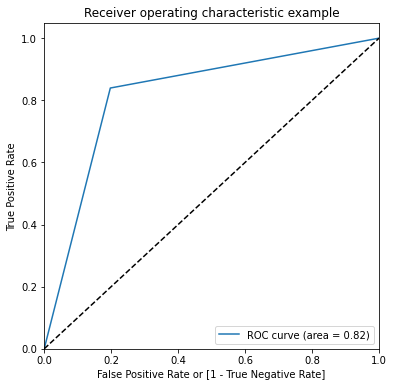

(array([0.        , 0.19752187, 1.        ]),
 array([0.        , 0.83951819, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [21]:
# Plotting ROC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

draw_roc(y_test, pred_test_pca)


##### Identifying important predictor attributes 
        
        Building our first model with all variables

####  MODEL 2
##### Logistic regression model with all Variables

In [22]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
model1= logm1.fit()
model1.summary()
print('AIC value of Model : ', model1.aic) 

AIC value of Model :  30839.02609451579


    Model Perfornace of Logistic Regression with all variables

In [23]:
# Getting the predicted values on the test set
X_test_m1 = sm.add_constant(X_test)
y_test_pred_m1 = model1.predict(X_test_m1)
y_pred_m1 = y_test_pred_m1.map(lambda x: 1 if x > 0.5 else 0)

# Confusion Metric
cm_model1 = metrics.confusion_matrix(y_test.values, y_pred_m1)
print('--------------------------- Confusion MAtrix for MODEL 2----------------')
print(cm_model1)
acc_model1 = metrics.accuracy_score(y_test.values, y_pred_m1)
print('------------------------------- Accuracy for MODEL 2----------------')
print(acc_model1)

# Calculating sensitivity of our logistic regression model-1
TP_model1 = cm_model1[1,1] # true positive
TN_model1 = cm_model1[0,0] # true negatives
FP_model1 = cm_model1[0,1] # false positives
FN_model1 = cm_model1[1,0] # false negatives
sensitivity_model1 = TP_model1/ float(TP_model1+FN_model1)
specificity_model1 = TN_model1 / float(TN_model1+FP_model1)

print('--------------------- Sensitivity of Model :', sensitivity_model1)
print('--------------------- Specificity of Model :', specificity_model1)


--------------------------- Confusion MAtrix for MODEL 2----------------
[[6846 1386]
 [1457 6762]]
------------------------------- Accuracy for MODEL 2----------------
0.827183757826272
--------------------- Sensitivity of Model : 0.8227278257695584
--------------------- Specificity of Model : 0.8316326530612245


### Performing RFE  (Recursive Feature Elimination)

In [24]:
logreg = lm.LogisticRegression()
rfe = RFE(logreg, 55)  #running RFE with 55 variables as output
y_train = pd.DataFrame(y_train)
rfe = rfe.fit(X_train, y_train)

       Check if Varaiable is Important or not!

In [25]:
#To check whether variable is important or not
#Variables and importance
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

## Column that is important as per rfe
col = X_train.columns[rfe.support_]

## Variables that are not important
X_train.columns[~rfe.support_]

Index(['roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2m_mou_7',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
       'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'isd_og_mou_6',
       'spl_og_mou_6', 'spl_og_mou_7', 'og_others_6', 'og_others_8',
       'total_og_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7',
       'loc_ic_mou_6', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_6',
       'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8',
       'std_ic_mou_6', 'std_ic_mou_7', 'spl_ic_mou_6', 'isd_ic_mou_6',
       'isd_ic_mou_7', 'isd_ic_mou_8', 'ic_others_6', 'ic_others_8',
       'total_rech_num_6', 'total_rech_amt_8', 'max_rech_amt_6',
       'max_rech_amt_8', 'last_

####  Assessing the RFE model with StatsModels

In [26]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
rfe_model2 = logm2.fit()
rfe_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                38385
Model:                            GLM   Df Residuals:                    38329
Model Family:                Binomial   Df Model:                           55
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16164.
Date:                Sun, 17 May 2020   Deviance:                       32328.
Time:                        23:30:17   Pearson chi2:                 4.47e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.2247      0.016    -13.967      0.000      -0.256      -0.193
arpu_6                 0.2020      0.054      3.765      0.000       0.097       0.307
arpu_7                 0.1331      0.056      2.356      0.018       0.022       0.244
arpu_8                 0.2419      0.039      6.254      0.000       0.166       0.318
roam_ic_mou_6          0.1252      0.026      4.796      0.000       0.074       0.176
roam_og_mou_6         -0.0955      0.025     -3.812      0.000      -0.145      -0.046
roam_og_mou_7          0.3831      0.024     16.188      0.000       0.337       0.430
loc_og_t2t_mou_6       0.1032      0.027      3.879      0.000       0.051       0.155
loc_og_t2t_mou_7       0.1345      0.041      3.304      0.001       0.055       0.214
loc_og_t2t_mou_8      -0.6702      0.324     -2.065      0.039      -1.306      -0.034
loc_og_t2m_mou_6      -0.1563      0.022     -7.154      0.000      -0.199      -0.114
loc_og_t2m_mou_8      -0.3954      0.382     -1.034      0.301      -1.145       0.354
loc_og_t2f_mou_7      -0.2218      0.039     -5.661      0.000      -0.299      -0.145
loc_og_mou_8          -1.6586      2.488     -0.667      0.505      -6.535       3.218
std_og_t2m_mou_7       0.1852      0.036      5.184      0.000       0.115       0.255
std_og_t2m_mou_8      -0.2062      0.036     -5.746      0.000      -0.277      -0.136
std_og_mou_8          -3.6659      4.625     -0.793      0.428     -12.730       5.398
isd_og_mou_7           0.1544      0.052      2.944      0.003       0.052       0.257
isd_og_mou_8          -0.4115      0.301     -1.368      0.171      -1.001       0.178
spl_og_mou_8          -0.2065      0.157     -1.313      0.189      -0.515       0.102
og_others_7            0.1094      0.043      2.573      0.010       0.026       0.193
total_og_mou_7         0.3882      0.041      9.446      0.000       0.308       0.469
total_og_mou_8         3.6765      5.313      0.692      0.489      -6.736      14.090
loc_ic_t2t_mou_7      -0.1954      0.116     -1.687      0.092      -0.422       0.032
loc_ic_t2m_mou_7       0.2811      0.152      1.850      0.064      -0.017       0.579
loc_ic_t2m_mou_8      -0.8285      0.092     -9.038      0.000      -1.008      -0.649
loc_ic_t2f_mou_8      -0.1077      0.045     -2.409      0.016      -0.195      -0.020
loc_ic_mou_7           0.1860      0.237      0.783      0.434      -0.279       0.651
loc_ic_mou_8          -0.4504      0.150     -3.005      0.003      -0.744      -0.157
std_ic_t2t_mou_6       0.0962      0.027      3.535      0.000       0.043       0.150
std_ic_t2t_mou_7       0.1033      0.048      2.145      0.032       0.009       0.198
std_ic_t2m_mou_7      -0.1897      0.047     -4.043      0.000      -0.282      -0.098
std_ic_t2m_mou_8       0.5083      0.0

#####  Getting the predicted values on the test set

In [27]:
X_test_sm = sm.add_constant(X_test[col])
y_test_pred_rfe = rfe_model2.predict(X_test_sm)
y_test_pred_rfe[:10]

y_pred_m2 = y_test_pred_rfe.map(lambda x: 1 if x > 0.5 else 0)

# Confusion Metric
cm_model2 = metrics.confusion_matrix(y_test.values, y_pred_m2)
print('--------------------------- Confusion MAtrix ----------------')
print(cm_model2)
acc_model2 = metrics.accuracy_score(y_test.values, y_pred_m2)
print('------------------------------- Accuracy ----------------')
print(acc_model2) #0.8024 accuracy

# Calculating sensitivity of our logistic regression model-1
TP_model2 = cm_model2[1,1] # true positive
TN_model2 = cm_model2[0,0] # true negatives
FP_model2 = cm_model2[0,1] # false positives
FN_model2 = cm_model2[1,0] # false negatives
sensitivity_model2 = TP_model2/ float(TP_model2+FN_model2) 
specificity_model2 = TN_model2 / float(TN_model2+FP_model2)


print('--------------------- Sensitivity of Model :', sensitivity_model2)
print('--------------------- Specificity of Model :', specificity_model2)


--------------------------- Confusion MAtrix ----------------
[[6625 1607]
 [1316 6903]]
------------------------------- Accuracy ----------------
0.8223208315603915
--------------------- Sensitivity of Model : 0.8398831974692785
--------------------- Specificity of Model : 0.8047862001943634


### VIF values of the feature variables 

In [28]:
# Check for the VIF values of the feature variables.
col = list(X_train.columns)
flag = True
i=0
while flag:
    print("iteration ",i)#iteration count
    i=i+1
    vif = pd.DataFrame()
    vif['Features'] = X_train[col].columns
    vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    if vif[vif['VIF'] > 4.0].count()['VIF'] == 0:
        flag = False
        break
    else:
        var_max_vif = vif[vif['VIF'] == max(vif['VIF'])]['Features'].to_list()
        final_list = list(set(col).difference(set(var_max_vif)))
        col = final_list

vif['Features'].to_list()

iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20
iteration  21
iteration  22
iteration  23
iteration  24
iteration  25
iteration  26
iteration  27
iteration  28
iteration  29
iteration  30
iteration  31
iteration  32
iteration  33
iteration  34
iteration  35


['max_rech_data_6',
 'std_og_t2t_mou_7',
 'std_og_t2m_mou_7',
 'total_rech_num_7',
 'loc_og_t2t_mou_7',
 'loc_ic_t2m_mou_7',
 'vol_3g_mb_7',
 'arpu_2g_7',
 'roam_og_mou_7',
 'loc_ic_t2f_mou_7',
 'loc_ic_t2m_mou_8',
 'roam_ic_mou_7',
 'fb_user_6',
 'jul_vbc_3g',
 'isd_ic_mou_7',
 'arpu_3g_6',
 'loc_og_t2t_mou_8',
 'std_ic_t2t_mou_7',
 'arpu_7',
 'fb_user_7',
 'max_rech_amt_8',
 'total_rech_num_8',
 'ic_others_7',
 'std_ic_t2f_mou_7',
 'spl_og_mou_7',
 'std_og_t2f_mou_7',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2m_mou_6',
 'std_ic_t2f_mou_6',
 'loc_ic_t2f_mou_8',
 'roam_og_mou_6',
 'loc_og_t2f_mou_6',
 'fb_user_8',
 'max_rech_amt_6',
 'std_ic_t2t_mou_6',
 'roam_ic_mou_6',
 'loc_ic_t2t_mou_8',
 'std_og_t2t_mou_8',
 'isd_og_mou_6',
 'std_og_t2t_mou_6',
 'total_rech_num_6',
 'isd_og_mou_8',
 'roam_og_mou_8',
 'std_og_t2m_mou_6',
 'aug_vbc_3g',
 'loc_og_t2c_mou_7',
 'std_og_t2f_mou_8',
 'loc_ic_t2f_mou_6',
 'std_ic_t2m_mou_7',
 'isd_ic_mou_6',
 'vol_2g_mb_7',
 'loc_og_t2m_mou_8',
 'roam_ic_mou_8',
 '

#### Result

        Above we, get List of columns that does not have Multi-Collinearity at threshold VIF value = 4 and,
        therefore is taken into consideration for Logistic regression.
        
##### NOTE : Columns from VIF is copied below for avoiding computation complexity.

In [29]:
vif.columns
column_vif =['max_rech_data_6','std_og_t2t_mou_7','std_og_t2m_mou_7','total_rech_num_7','loc_og_t2t_mou_7',
 'loc_ic_t2m_mou_7','vol_3g_mb_7','arpu_2g_7', 'roam_og_mou_7', 'loc_ic_t2f_mou_7', 'loc_ic_t2m_mou_8',
 'roam_ic_mou_7','fb_user_6', 'jul_vbc_3g', 'isd_ic_mou_7', 'arpu_3g_6', 'loc_og_t2t_mou_8', 'std_ic_t2t_mou_7',
 'arpu_7', 'fb_user_7', 'max_rech_amt_8', 'total_rech_num_8', 'ic_others_7', 'std_ic_t2f_mou_7', 'spl_og_mou_7',
 'std_og_t2f_mou_7', 'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'loc_ic_t2f_mou_8', 'roam_og_mou_6',
 'loc_og_t2f_mou_6', 'fb_user_8', 'max_rech_amt_6', 'std_ic_t2t_mou_6', 'roam_ic_mou_6', 'loc_ic_t2t_mou_8', 'std_og_t2t_mou_8',
 'isd_og_mou_6', 'std_og_t2t_mou_6', 'total_rech_num_6', 'isd_og_mou_8', 'roam_og_mou_8', 'std_og_t2m_mou_6', 'aug_vbc_3g', 'loc_og_t2c_mou_7',
 'std_og_t2f_mou_8', 'loc_ic_t2f_mou_6', 'std_ic_t2m_mou_7', 'isd_ic_mou_6', 'vol_2g_mb_7', 'loc_og_t2m_mou_8', 'roam_ic_mou_8', 'arpu_3g_8', 'ic_others_8',
 'last_day_rch_amt_8', 'std_og_t2m_mou_8', 'ic_others_6', 'isd_ic_mou_8', 'max_rech_amt_7', 'loc_og_t2t_mou_6', 'last_day_rch_amt_6', 'std_ic_t2f_mou_8',
 'jun_vbc_3g', 'loc_og_t2m_mou_6', 'loc_ic_t2t_mou_6', 'spl_og_mou_6', 'spl_og_mou_8', 'loc_og_t2f_mou_8', 'std_ic_t2m_mou_8', 'vol_2g_mb_6',
 'std_ic_t2m_mou_6', 'vol_2g_mb_8', 'og_others_8', 'last_day_rch_amt_7', 'loc_og_t2c_mou_8', 'std_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'night_pck_user_7',
 'std_ic_t2t_mou_8', 'night_pck_user_8', 'spl_ic_mou_6', 'night_pck_user_6', 'spl_ic_mou_7', 'og_others_6', 'aon', 'spl_ic_mou_8']



    Subsetting the X_train and X_test Dataframes for the Features we get after implementing VIF

In [30]:
X_train_vif1 = X_train[column_vif]
X_test_vif1 = X_test[column_vif]

### Logisitc Regression after VIF 

In [31]:
# Let's re-run the model using the selected variables
X_train_rfe1 = sm.add_constant(X_train[column_vif])
log_vif1 = sm.GLM(y_train,X_train_rfe1, family = sm.families.Binomial())
model3 = log_vif1.fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                38385
Model:                            GLM   Df Residuals:                    38297
Model Family:                Binomial   Df Model:                           87
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16266.
Date:                Sun, 17 May 2020   Deviance:                       32531.
Time:                        23:35:20   Pearson chi2:                 1.03e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.2125      0.016    -13.316      0.000      -0.244      -0.181
max_rech_data_6       -0.0735      0.029     -2.519      0.012      -0.131      -0.016
std_og_t2t_mou_7       0.1402      0.031      4.552      0.000       0.080       0.201
std_og_t2m_mou_7       0.3497      0.033     10.451      0.000       0.284       0.415
total_rech_num_7       0.1385      0.030      4.671      0.000       0.080       0.197
loc_og_t2t_mou_7       0.2115      0.039      5.401      0.000       0.135       0.288
loc_ic_t2m_mou_7       0.6670      0.041     16.332      0.000       0.587       0.747
vol_3g_mb_7           -0.0277      0.025     -1.102      0.270      -0.077       0.022
arpu_2g_7              0.1736      0.027      6.480      0.000       0.121       0.226
roam_og_mou_7          0.2646      0.031      8.448      0.000       0.203       0.326
loc_ic_t2f_mou_7       0.0604      0.035      1.736      0.083      -0.008       0.129
loc_ic_t2m_mou_8      -1.4200      0.055    -25.842      0.000      -1.528      -1.312
roam_ic_mou_7          0.0554      0.037      1.517      0.129      -0.016       0.127
fb_user_6              0.0618      0.026      2.403      0.016       0.011       0.112
jul_vbc_3g             0.0600      0.025      2.417      0.016       0.011       0.109
isd_ic_mou_7           0.0546      0.032      1.712      0.087      -0.008       0.117
arpu_3g_6              0.0891      0.027      3.290      0.001       0.036       0.142
loc_og_t2t_mou_8      -0.5957      0.052    -11.415      0.000      -0.698      -0.493
std_ic_t2t_mou_7       0.2081      0.038      5.481      0.000       0.134       0.283
arpu_7                 0.0654      0.030      2.156      0.031       0.006       0.125
fb_user_7              0.0112      0.024      0.460      0.645      -0.037       0.059
max_rech_amt_8         0.0719      0.025      2.887      0.004       0.023       0.121
total_rech_num_8      -0.4609      0.029    -15.673      0.000      -0.519      -0.403
ic_others_7           -0.1164      0.037     -3.158      0.002      -0.189      -0.044
std_ic_t2f_mou_7       0.0428      0.032      1.355      0.176      -0.019       0.105
spl_og_mou_7           0.0067      0.026      0.261      0.794      -0.043       0.057
std_og_t2f_mou_7       0.0045      0.028      0.160      0.873      -0.050       0.059
loc_ic_t2t_mou_7       0.1011      0.034      2.976      0.003       0.035       0.168
loc_ic_t2m_mou_6       0.0974      0.032      3.036      0.002       0.035       0.160
std_ic_t2f_mou_6       0.0193      0.031      0.621      0.535      -0.042       0.080
loc_ic_t2f_mou_8      -0.2182      0.043     -5.112      0.000      -0.302      -0.135
roam_og_mou_6          0.0055      0.025      0.217      0.829      -0.044       0.055
loc_og_t2f_mou_6      -0.0597      0.0

##### Analyzing p-values from above.

    At 5% significance level,we are Identifying the variables that are important for the churn.
    Below, code keeps all the columns where p-value < 0.05


In [32]:
# The Function below converts model3 summary to dataframe

def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df[["coeff","pvals","conf_lower","conf_higher"]]
    return results_df

df_model3_summary = results_summary_to_dataframe(model3)
# We have kept significance level 5%

In [33]:
list_column_model4 = df_model3_summary[df_model3_summary['pvals'] <= 0.05].index.to_list()[1:]

####  MODEL 3: Logisitc Regression after selecting important variables

    Let's re-run the model using the selected variables

In [34]:
X_train_vif2 = sm.add_constant(X_train[list_column_model4])
log_vif2 = sm.GLM(y_train,X_train_vif2, family = sm.families.Binomial())
model4 = log_vif2.fit()
model4.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                38385
Model:                            GLM   Df Residuals:                    38322
Model Family:                Binomial   Df Model:                           62
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16282.
Date:                Sun, 17 May 2020   Deviance:                       32564.
Time:                        23:37:49   Pearson chi2:                 1.04e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.2126      0.016    -13.355      0.000      -0.244      -0.181
max_rech_data_6       -0.0872      0.028     -3.061      0.002      -0.143      -0.031
std_og_t2t_mou_7       0.1453      0.030      4.775      0.000       0.086       0.205
std_og_t2m_mou_7       0.3498      0.033     10.559      0.000       0.285       0.415
total_rech_num_7       0.1467      0.029      5.043      0.000       0.090       0.204
loc_og_t2t_mou_7       0.2164      0.039      5.526      0.000       0.140       0.293
loc_ic_t2m_mou_7       0.6826      0.040     16.969      0.000       0.604       0.761
arpu_2g_7              0.1670      0.023      7.179      0.000       0.121       0.213
roam_og_mou_7          0.2885      0.025     11.504      0.000       0.239       0.338
loc_ic_t2m_mou_8      -1.4278      0.055    -26.115      0.000      -1.535      -1.321
fb_user_6              0.0741      0.023      3.238      0.001       0.029       0.119
jul_vbc_3g             0.0533      0.022      2.461      0.014       0.011       0.096
arpu_3g_6              0.0893      0.026      3.476      0.001       0.039       0.140
loc_og_t2t_mou_8      -0.5993      0.052    -11.481      0.000      -0.702      -0.497
std_ic_t2t_mou_7       0.2045      0.038      5.405      0.000       0.130       0.279
arpu_7                 0.0579      0.029      2.026      0.043       0.002       0.114
max_rech_amt_8         0.0746      0.024      3.075      0.002       0.027       0.122
total_rech_num_8      -0.4658      0.029    -15.954      0.000      -0.523      -0.409
ic_others_7           -0.1162      0.033     -3.494      0.000      -0.181      -0.051
loc_ic_t2t_mou_7       0.1053      0.034      3.110      0.002       0.039       0.172
loc_ic_t2m_mou_6       0.0986      0.032      3.097      0.002       0.036       0.161
loc_ic_t2f_mou_8      -0.1540      0.032     -4.844      0.000      -0.216      -0.092
loc_og_t2f_mou_6      -0.0568      0.029     -1.966      0.049      -0.113      -0.000
fb_user_8             -0.3914      0.022    -18.099      0.000      -0.434      -0.349
max_rech_amt_6         0.1922      0.019     10.008      0.000       0.155       0.230
std_ic_t2t_mou_6       0.1313      0.026      5.080      0.000       0.081       0.182
roam_ic_mou_6          0.1304      0.022      5.956      0.000       0.087       0.173
loc_ic_t2t_mou_8      -0.4024      0.045     -8.927      0.000      -0.491      -0.314
std_og_t2t_mou_8      -0.2582      0.025    -10.254      0.000      -0.308      -0.209
isd_og_mou_6           0.0459      0.027      1.697      0.090      -0.007       0.099
std_og_t2t_mou_6       0.1430      0.024      6.008      0.000       0.096       0.190
total_rech_num_6       0.1597      0.023      6.877      0.000       0.114       0.205
roam_og_mou_8          0.0774      0.0

    
        Above Model Evaluation for Test dataset with selected features

In [35]:
# Getting the predicted values on the test set
X_test_vif2 = sm.add_constant(X_test[list_column_model4])
y_test_pred_vif2 = model4.predict(X_test_vif2)
y_test_pred_vif2[:10]

y_pred_vif2 = y_test_pred_vif2.map(lambda x: 1 if x > 0.5 else 0)

# Confusion Metric
cm_model4 = metrics.confusion_matrix(y_test.values, y_pred_vif2)
print('--------------------------- Confusion MAtrix ----------------')
print(cm_model4)
acc_model4 = metrics.accuracy_score(y_test.values, y_pred_vif2)
print('--------------------------- Accuracy ----------------')
print(acc_model4) #0.8457 accuracy

# Calculating sensitivity of our logistic regression model-4
TP_model4 = cm_model4[1,1] # true positive
TN_model4 = cm_model4[0,0] # true negatives
FP_model4 = cm_model4[0,1] # false positives
FN_model4 = cm_model4[1,0] # false negatives
sensitivity_model4 = TP_model4/ float(TP_model4+FN_model4)  #0.8631041355256602
specificity_model4 = TN_model4 / float(TN_model4+FP_model4) #0.8285643503034807

print('--------------------- Sensitivity of Model :', sensitivity_model4)
print('--------------------- Specificity of Model :', specificity_model4)


--------------------------- Confusion MAtrix ----------------
[[6684 1548]
 [1309 6910]]
--------------------------- Accuracy ----------------
0.8263327457297429
--------------------- Sensitivity of Model : 0.8407348825891228
--------------------- Specificity of Model : 0.8119533527696793


### Decision Tree Classifier 

        Fitting the decision tree with DEFAULT Hyperparameters

In [36]:
dt_default = DecisionTreeClassifier()
dt_default.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

    Evaluating above Model on X_test

In [37]:
# __________________________ Making predictions______________________________

y_pred_dt_default = dt_default.predict(X_test)

# Printing classification report
cm_dt_default = metrics.confusion_matrix(y_test, y_pred_dt_default)
print('--------------------------- Confusion MAtrix ----------------')
print(cm_dt_default)
dt_default_accuracy = metrics.accuracy_score(y_test, y_pred_dt_default) #0.9698776473510962
print('--------------------------- Accuracy ----------------')
print(dt_default_accuracy)

# Calculating sensitivity of our default  Decision Tree
TN_model_dt_default = cm_dt_default[0,0] # true negatives
FP_model_dt_default = cm_dt_default[0,1] # false positives
FN_model_dt_default = cm_dt_default[1,0] # false negatives
TP_model_dt_default = cm_dt_default[1,1] # true positive
sensitivity_dt_default = TP_model_dt_default/ float(TP_model_dt_default+FN_model_dt_default)  #0.9993771798704534
specificity_dt_default = TN_model_dt_default / float(TN_model_dt_default+FP_model_dt_default) #0.9405425492382015

print('--------------------- Sensitivity of Model :', sensitivity_dt_default)
print('--------------------- Specificity of Model :', specificity_dt_default)


--------------------------- Confusion MAtrix ----------------
[[7691  541]
 [   7 8212]]
--------------------------- Accuracy ----------------
0.9666889550787187
--------------------- Sensitivity of Model : 0.9991483148801558
--------------------- Specificity of Model : 0.9342808551992225



###                               Hyperparameter Tuning for Decision Tree 


In [38]:
# ______________________________ Create the parameter grid _________________________
param_grid = {
    'max_depth': range(5, 50, 10),
    'min_samples_leaf': range(5, 150, 50),
    'min_samples_split': range(5, 150, 50),
    #'max_features':range(5,73),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# _____________________________ Instantiate the grid search model _______________
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, cv = n_folds, verbose = 1)

# _____________________________ Fit the grid search to the data _________________
grid_search.fit(X_train,y_train)
print("__________best accuracy___________", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed: 12.2min finished


__________best accuracy___________ 0.9477139507620166
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=25, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


        Based on the result from above Hyperparameter tuning, we get optimal values for our model
        
 ##### Model fitting using optimal values from above 

In [39]:
clf_optimal = DecisionTreeClassifier(criterion = 'entropy',
                                  random_state = 100,
                                  max_depth=25,
                                  min_samples_leaf=5,
                                  min_samples_split=5)
clf_optimal.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=25, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')

        Evaluating above model on Test Data 

In [41]:
####################### Getting Features Importance ###############################
# Making predictions
y_pred_dt_optimal = clf_optimal.predict(X_test)

# Printing classification report
cm_dt_optimal = metrics.confusion_matrix(y_test, y_pred_dt_optimal)
print('--------------------------- Confusion MAtrix ----------------')
print(cm_dt_optimal)
dt_optimal_accuracy = metrics.accuracy_score(y_test, y_pred_dt_optimal) #0.9698776473510962
print('--------------------------- Accuracy ----------------')
print(dt_optimal_accuracy)
# Calculating sensitivity of our default  Decision Tree
TN_model_dt_optimal = cm_dt_optimal[0,0] # true negatives
FP_model_dt_optimal = cm_dt_optimal[0,1] # false positives
FN_model_dt_optimal = cm_dt_optimal[1,0] # false negatives
TP_model_dt_optimal = cm_dt_optimal[1,1] # true positive
sensitivity_dt_optimal = TP_model_dt_optimal/ float(TP_model_dt_optimal+FN_model_dt_optimal)  #0.2771798704534
specificity_dt_optimal = TN_model_dt_optimal / float(TN_model_dt_optimal+FP_model_dt_optimal) #0.9405425492382015

print('--------------------- Sensitivity of Model :', sensitivity_dt_optimal)
print('--------------------- Specificity of Model :', specificity_dt_optimal)


--------------------------- Confusion MAtrix ----------------
[[7614  618]
 [ 115 8104]]
--------------------------- Accuracy ----------------
0.95544343808887
--------------------- Sensitivity of Model : 0.9860080301739871
--------------------- Specificity of Model : 0.9249271137026239


In [42]:

from sklearn import tree


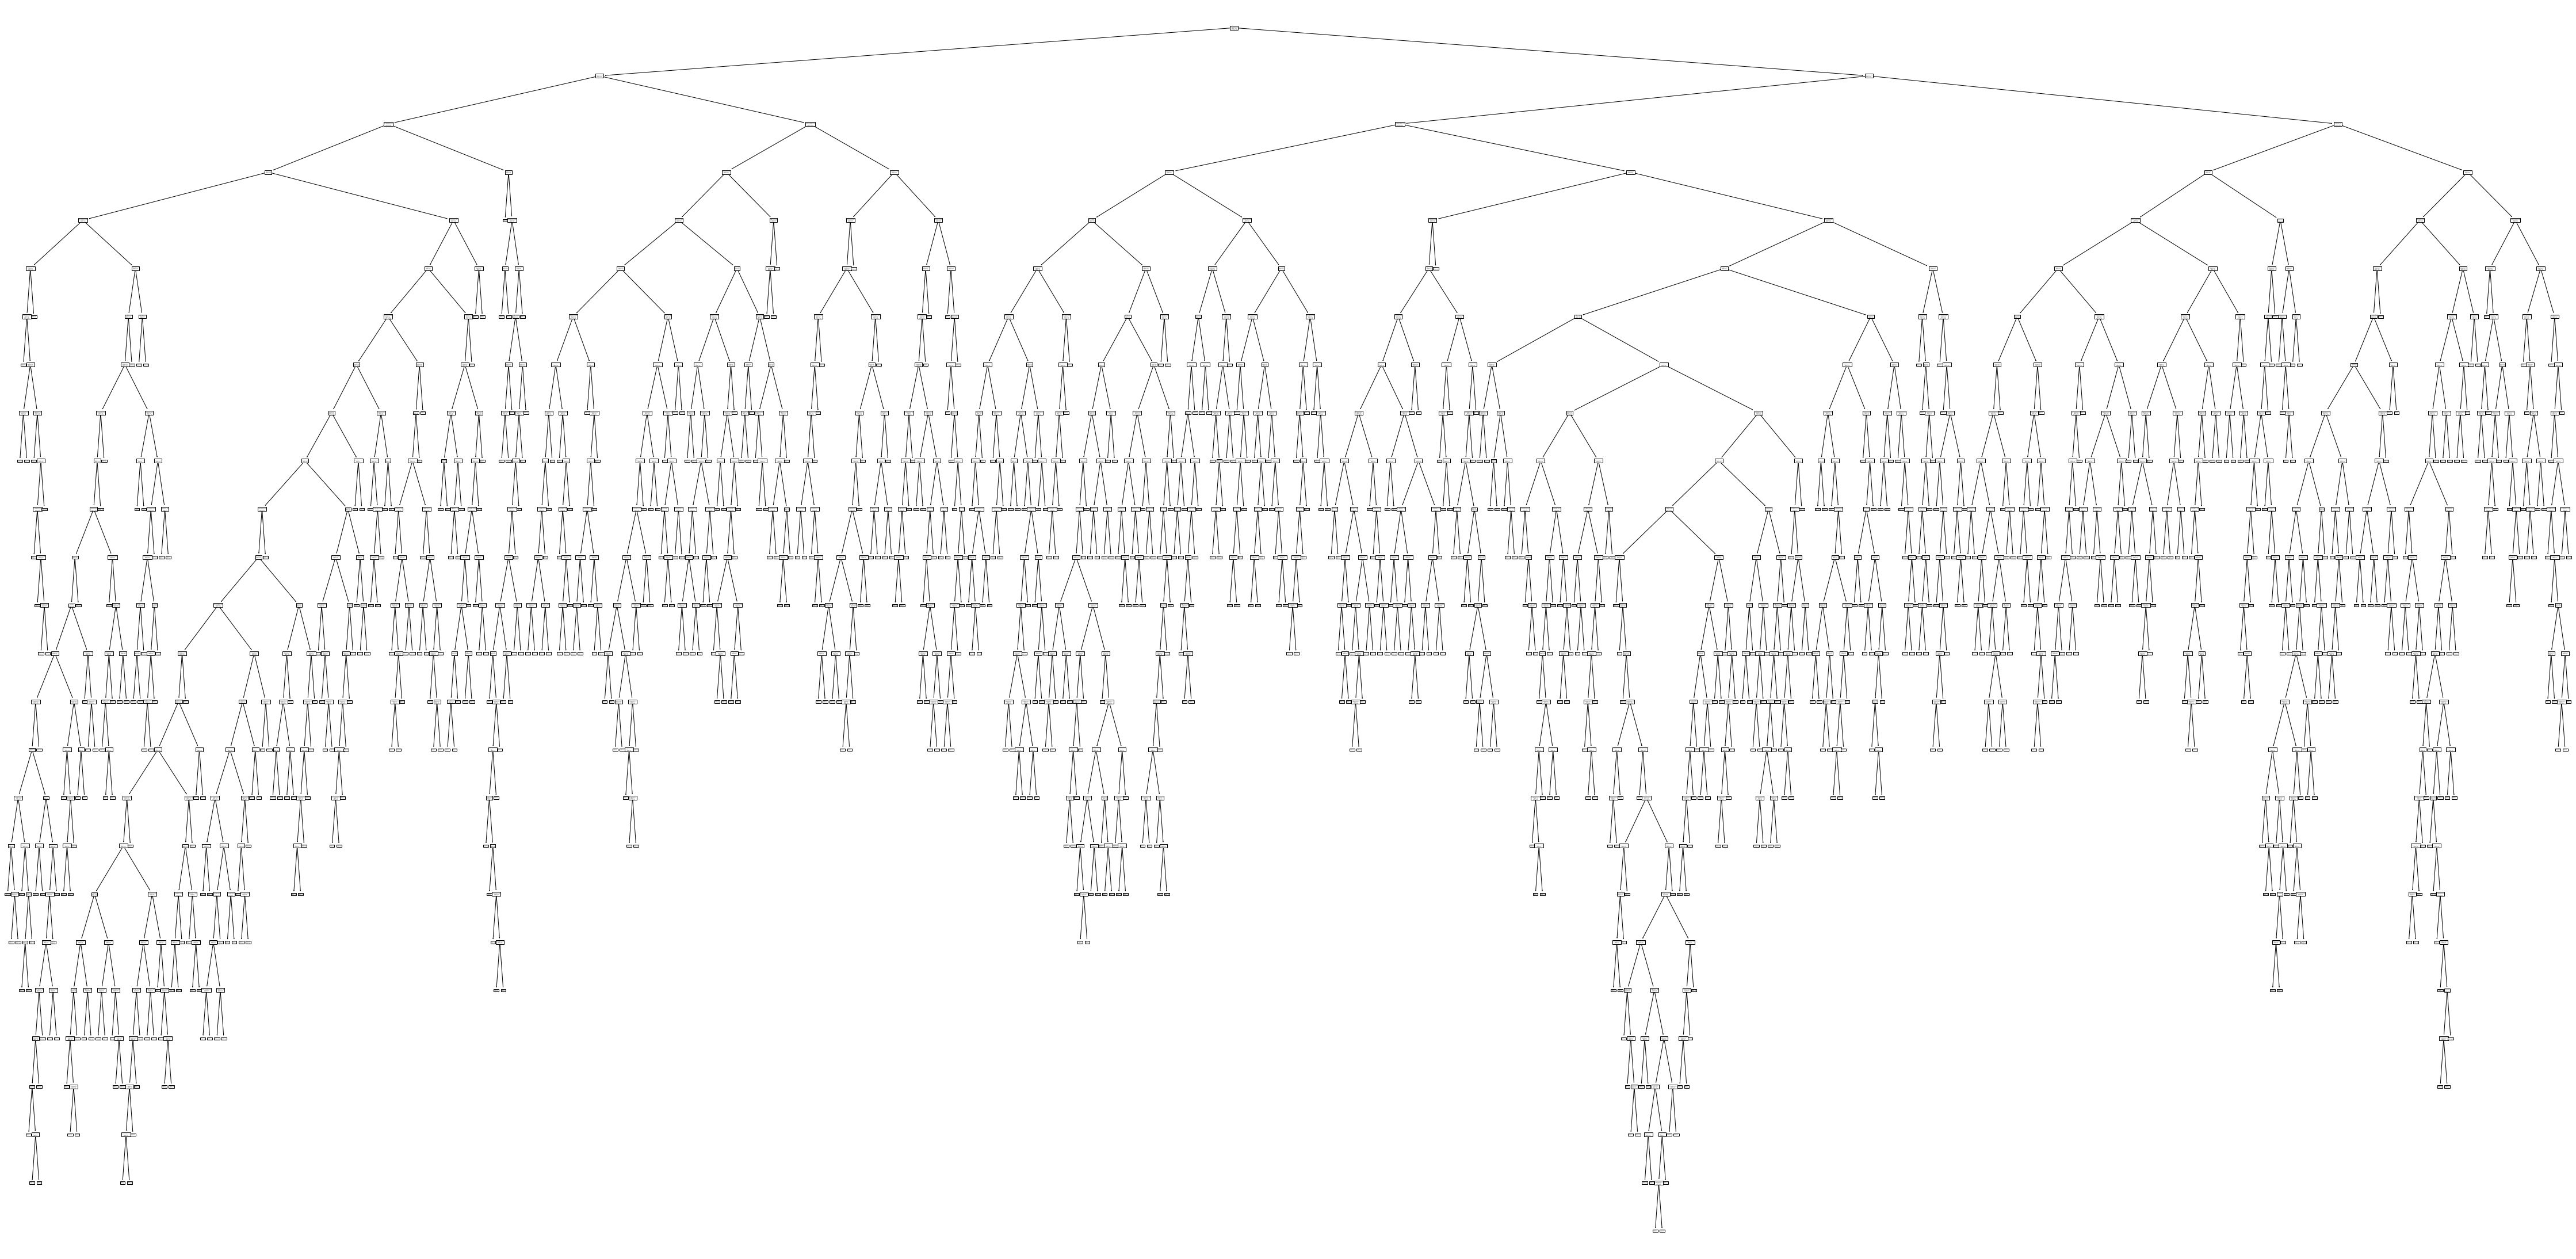

In [43]:
plt.figure(figsize=(80,40))  # customize according to the size of your tree
_ = tree.plot_tree(clf_optimal, feature_names = X_test.columns)
plt.show()